<a href="https://colab.research.google.com/github/kunai-3txk/MachineLearning/blob/main/MicroBusiness_EDA_Predict_20230118.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/imnaho/eda-predict

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)0

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb
#import xgboost as xgb
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [4]:
#load
train_df=pd.read_csv('/content/drive/MyDrive/Kaggle/microbusiness/train.csv')
test_df=pd.read_csv('/content/drive/MyDrive/Kaggle/microbusiness/test.csv')
df_census=pd.read_csv('/content/drive/MyDrive/Kaggle/microbusiness/census_starter.csv')

#looks like there is no null column in train and test data

#check for null columns
cols_with_missing = [col for col in train_df.columns if train_df[col].isnull().any()]
print('number of missing columns in train data is : ',len(cols_with_missing))
print(cols_with_missing)
cols_with_missing = [col for col in test_df.columns if test_df[col].isnull().any()]
print('number of missing columns in test data is : ',len(cols_with_missing))
print(cols_with_missing)

#show
train_df.head()

number of missing columns in train data is :  0
[]
number of missing columns in test data is :  0
[]


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [5]:
print('train dat.add_suffix is below')
print(train_df.groupby('first_day_of_month').count().index)
print('')
print('test data is below')
print(test_df.groupby('first_day_of_month').count().index)

train dat.add_suffix is below
Index(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
       '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
       '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
       '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
       '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
       '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
       '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
       '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01'],
      dtype='object', name='first_day_of_month')

test data is below
Index(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
       '2023-04-01', '2023-05-01', '2023-06-01'],
      dtype='object', name='first_day_of_month')


we get 2019/08~ 2022/10 for training data, and predict 2022/11~2023/6 (=8 month density for each cfips)

In [6]:
#add year and month columns
for df_ in [train_df,test_df]:
    df_['year']=df_['first_day_of_month'].str.split('-',expand=True).iloc[:,0]
    df_['month']=df_['first_day_of_month'].str.split('-',expand=True).iloc[:,1]
    df_['year_month']=df_['year']+df_['month']

    df_['year']=df_['year'].astype('int')
    df_['month']=df_['month'].astype('int')
    
train_df.describe()

,cfips,microbusiness_density,active,year,month
count,122265.000000,122265.000000,1.222650e+05,122265.000000,122265.000000
mean,30376.037640,3.817671,6.442858e+03,2020.692308,6.692308
std,15143.508721,4.991087,3.304001e+04,0.991089,3.390452
min,1001.000000,0.000000,0.000000e+00,2019.000000,1.000000
25%,18177.000000,1.639344,1.450000e+02,2020.000000,4.000000
50%,29173.000000,2.586543,4.880000e+02,2021.000000,7.000000
75%,45077.000000,4.519231,2.124000e+03,2022.000000,10.000000
max,56045.000000,284.340030,1.167744e+06,2022.000000,12.000000


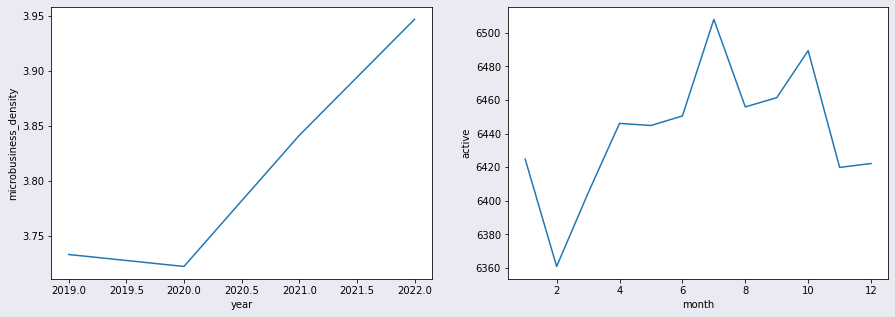

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), facecolor='#EAEAF2')
sns.lineplot(data=train_df.groupby('year').mean(),x='year',y='microbusiness_density',ax=axes[0])
sns.lineplot(data=train_df.groupby('month').mean(),x='month',y='active',ax=axes[1])
plt.show()

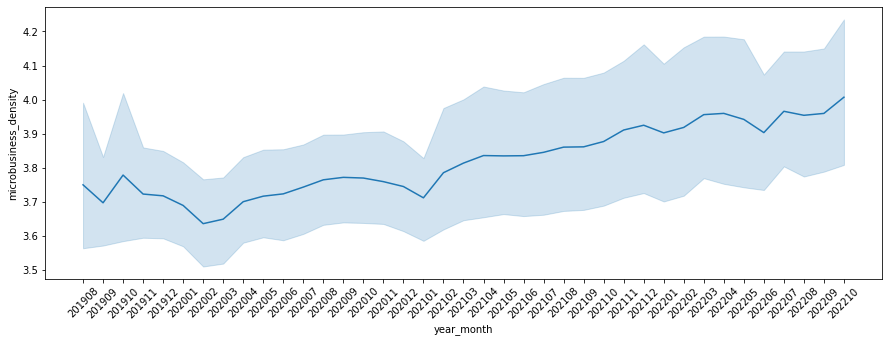

In [8]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=train_df,x='year_month',y='microbusiness_density')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

See if there are differences by state
Check the statistics first

In [9]:
sort_std=train_df.groupby(['state']).describe()['microbusiness_density'].sort_values('std').index
each_state=train_df.groupby(['state']).describe()['microbusiness_density'].sort_values('std')
each_state

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
District of Columbia,39.0,13.508989,0.294487,12.787801,13.269190,13.551914,13.697423,14.005946
Rhode Island,195.0,6.985363,1.207692,4.969075,6.032383,7.264053,8.120277,8.660382
West Virginia,2145.0,1.855457,1.241438,0.360211,0.878539,1.453722,2.542662,7.043378
Arkansas,2925.0,1.998925,1.497099,0.247328,0.974982,1.531890,2.445632,16.291933
Kansas,4095.0,2.463091,1.532490,0.562430,1.576070,2.148502,2.800141,14.035515
Mississippi,3198.0,1.696296,1.539697,0.000000,0.863192,1.305429,1.952426,14.852497
Alabama,2613.0,2.223274,1.584220,0.438305,1.202177,1.639288,2.709124,8.573463
Kentucky,4680.0,2.077160,1.731339,0.224027,0.953756,1.593625,2.662017,14.448168
Ohio,3432.0,3.034945,1.765796,0.637639,1.686132,2.482716,3.726996,9.845983


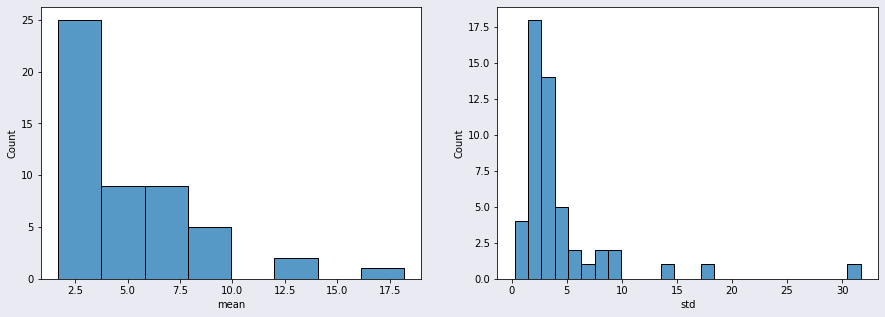

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), facecolor='#EAEAF2')
sns.histplot(data=each_state,x='mean',ax=axes[0])
sns.histplot(data=each_state,x='std',ax=axes[1])
plt.show()

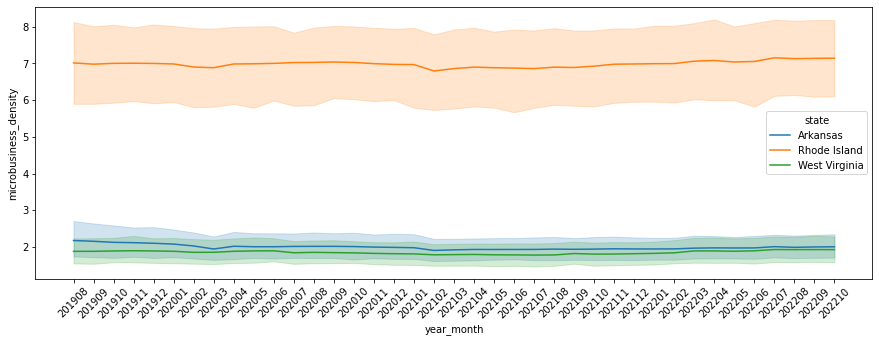

In [11]:
#stdの小さい州で傾向確認

plt.figure(figsize=(15, 5))
sns.lineplot(data=train_df[train_df['state'].isin(['Rhode Island','West Virginia','Arkansas'])],x='year_month',y='microbusiness_density',hue='state')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

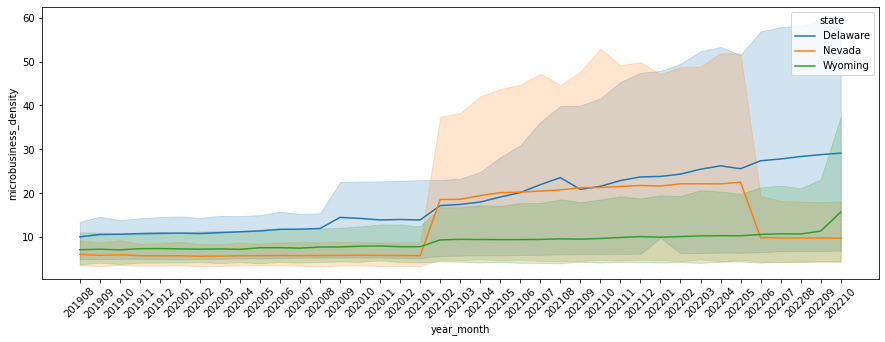

In [12]:
#stdの大きい州で傾向確認

plt.figure(figsize=(15, 5))
sns.lineplot(data=train_df[train_df['state'].isin(['Wyoming','Nevada','Delaware'])],x='year_month',y='microbusiness_density',hue='state')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

You can see the difference when you compare states with high standard deviation and states with low standard deviation.

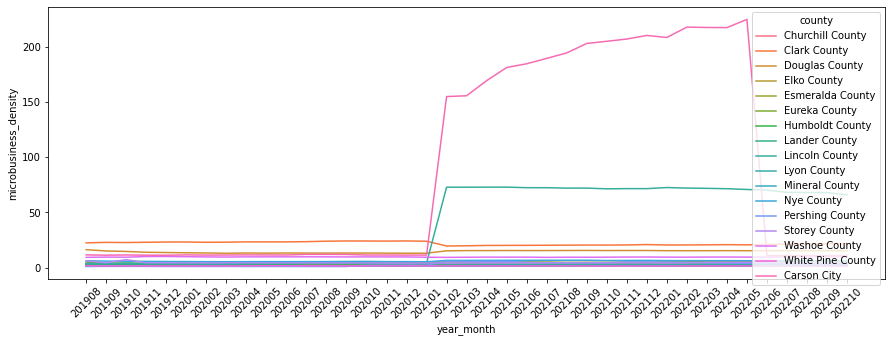

In [13]:
#plot Nevada(std=31.687018)
plt.figure(figsize=(15, 5))
sns.lineplot(data=train_df[train_df['state']=='Nevada'],x='year_month',y='microbusiness_density',hue='county')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

[32017, 32510]
std is :  5.533250958439538


<ipython-input-25-7aee85e0920e>:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('std is : ',train_df[(train_df['state']=='Nevada')&(~train_df['cfips'].isin(large_std_list))].std()['microbusiness_density'])


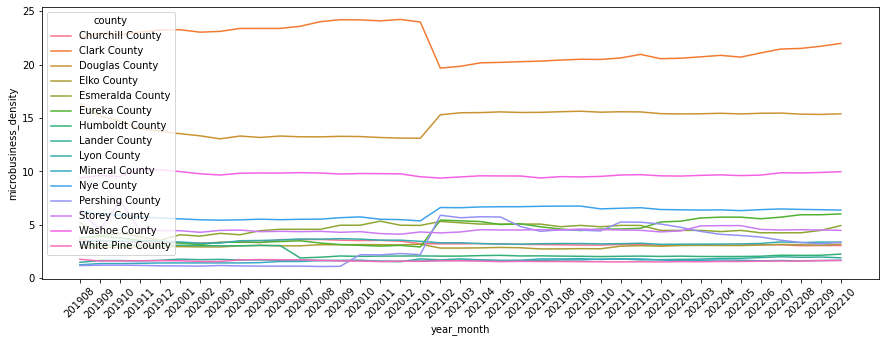

In [25]:
#What happens if we remove the two counties with the highest standard deviation in Nevada?

#stdの大きい２群のcfipsを取得する
#large_std_list = train_df[train_df['state']=='Nevada'].groupby('cfips').std().sort_values('microbusiness_density')['microbusiness_density'].tail(2).index.to_list()
large_std_list = train_df[train_df['state']=='Nevada'].groupby('cfips').std().sort_values('microbusiness_density').tail(2).index.to_list()
print(large_std_list)

#&はbit演算子、~ はbit inverse

print('std is : ',train_df[(train_df['state']=='Nevada')&(~train_df['cfips'].isin(large_std_list))].std()['microbusiness_density'])

#std=bigの2群を除いてのプロット
plt.figure(figsize=(15, 5))
sns.lineplot(data=train_df[(train_df['state']=='Nevada')&(~train_df['cfips'].isin(large_std_list))],x='year_month',y='microbusiness_density',hue='county')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()


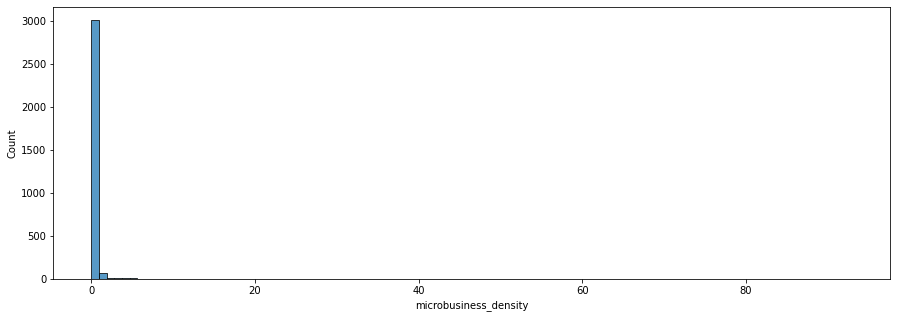

In [33]:
plt.figure(figsize=(15, 5))
sns.histplot(data=train_df.groupby('cfips').std(),x='microbusiness_density',bins=100)
plt.show()

In [34]:
#stdの外れ値を探す
train_df.groupby('cfips').std().sort_values('microbusiness_density').tail(10)

,microbusiness_density,active,year,month
cfips,,,,
55067,8.149953,1258.941088,1.00404,3.434759
12001,12.909924,28489.201772,1.00404,3.434759
17075,15.508998,3430.666978,1.00404,3.434759
10005,17.373696,33033.084522,1.00404,3.434759
8105,29.228311,2549.133320,1.00404,3.434759
32017,33.919938,1430.885201,1.00404,3.434759
16021,34.517087,3215.518768,1.00404,3.434759
56033,40.598497,9766.219869,1.00404,3.434759
46127,61.552190,6925.050881,1.00404,3.434759


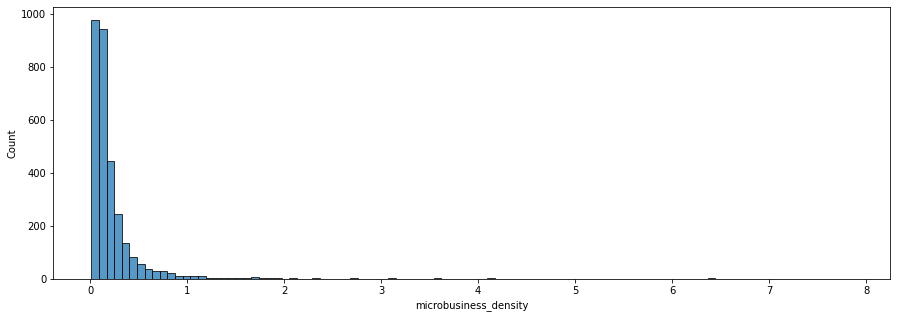

In [35]:
df_std=train_df.groupby('cfips').std() #stdだけのテーブル
plt.figure(figsize=(15, 5))
sns.histplot(data=df_std[df_std['microbusiness_density']<8],x='microbusiness_density',bins=100)
plt.show()

#外れ値を除くとstd<1にほとんどがプロットされている

In [38]:
#各カラムに時系列でチップを配置したDataFrameを作成する

cfips_list=train_df.groupby('cfips').count().index.tolist() #cfipsのリスト

train_each_cfips=pd.DataFrame()

for cfips in cfips_list:
    train_each_cfips[str(cfips)]=train_df.loc[train_df['cfips']==cfips,'microbusiness_density'].to_list()
    
#columns : cfips rows : year_month 
train_each_cfips.head()

<ipython-input-38-10faa6ac08b4>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_each_cfips[str(cfips)]=train_df.loc[train_df['cfips']==cfips,'microbusiness_density'].to_list()


,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
34,3.346197,8.507496,1.191678,1.275998,1.773202,0.937421,1.983687,2.724583,1.468978,1.117345,...,1.713062,6.101229,3.212966,113.19935,7.739897,2.783238,25.652266,3.906035,3.126551,1.803249
35,3.437971,8.573463,1.216926,1.326588,1.831783,0.950089,2.042414,2.782648,1.548280,1.141118,...,1.766595,6.191458,3.184532,114.09351,7.884691,2.836282,25.939260,3.981813,3.225807,1.803249
36,3.423852,8.491150,1.196728,1.292861,1.836289,0.962757,2.107667,2.788231,1.521846,1.131609,...,1.766595,6.221535,3.156099,113.44169,7.779387,2.811320,26.085369,3.974924,3.209264,1.785395
37,3.442677,8.341701,1.206827,1.315346,1.852060,0.975424,2.166395,2.809447,1.502964,1.131609,...,1.766595,6.178568,3.170316,128.26224,7.792550,2.811320,26.090586,3.995591,3.209264,1.785395
38,3.463856,8.359798,1.232074,1.287240,1.831783,0.988092,2.185970,2.800514,1.442544,1.117345,...,1.713062,6.217238,3.212966,227.75665,7.792550,2.823801,26.273220,4.009369,3.126551,1.785395


In [54]:
a=train_each_cfips.describe().T
a.describe()

#des > T > des ... 平均や標準偏差における傾向をつかむ方法
#標準偏差だけでなく、平均値にも異常値があるようです。

,count,mean,std,min,25%,50%,75%,max
count,3135.0,3135.000000,3135.000000,3135.000000,3135.000000,3135.000000,3135.000000,3135.000000
mean,39.0,3.817671,0.366977,3.339745,3.530910,3.782471,4.082877,4.544114
std,0.0,4.357161,2.440345,3.268582,3.516517,4.275259,5.922114,9.066226
min,39.0,0.063846,0.012630,0.000000,0.000000,0.000000,0.069662,0.100067
25%,39.0,1.644949,0.079533,1.435957,1.547610,1.634699,1.739872,1.875163
50%,39.0,2.597634,0.133925,2.304369,2.438546,2.583440,2.727371,2.896932
75%,39.0,4.499233,0.244651,4.071790,4.258763,4.504145,4.765838,5.086258
max,39.0,87.196625,93.048603,50.874134,51.746510,82.235069,191.766540,284.340030


In [55]:
list_min=a.sort_values('std')['std'].head(3).index.to_list()
list_min_ = [int(i) for i in list_min]

list_mid=a[a['std']>0.1].sort_values('std').head(3).index.to_list()
list_mid_1 = [int(i) for i in list_mid]

list_mid=a[a['std']>0.13].sort_values('std').head(3).index.to_list()
list_mid_2= [int(i) for i in list_mid]

list_max=a.sort_values('std').tail(3).index.to_list()
list_max_ = [int(i) for i in list_max]

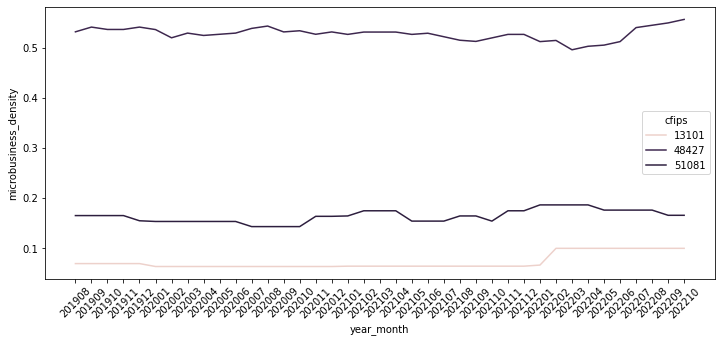

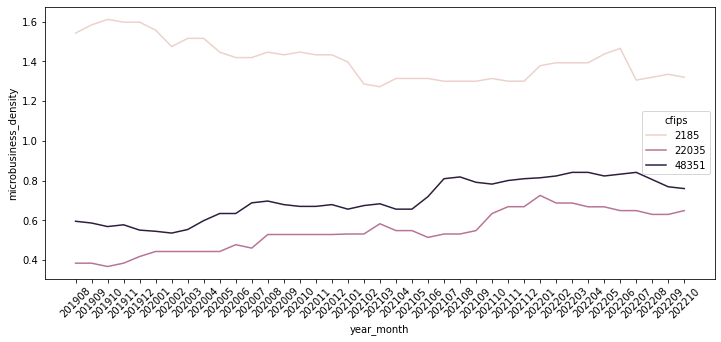

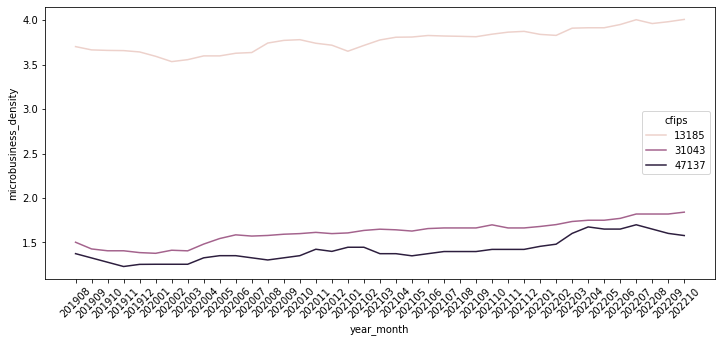

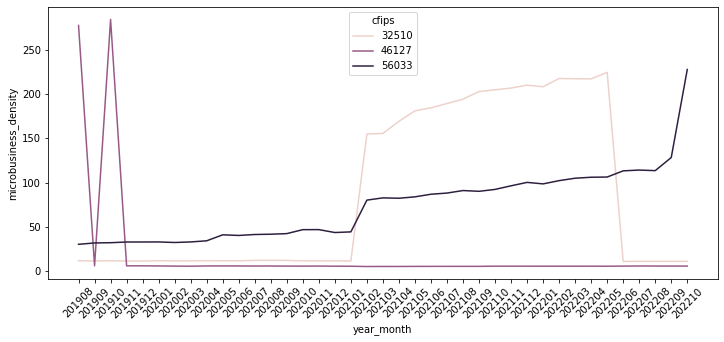

In [56]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=train_df[train_df['cfips'].isin(list_min_)],x='year_month',y='microbusiness_density',hue='cfips')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=train_df[train_df['cfips'].isin(list_mid_1)],x='year_month',y='microbusiness_density',hue='cfips')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=train_df[train_df['cfips'].isin(list_mid_2)],x='year_month',y='microbusiness_density',hue='cfips')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=train_df[train_df['cfips'].isin(list_max_)],x='year_month',y='microbusiness_density',hue='cfips')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

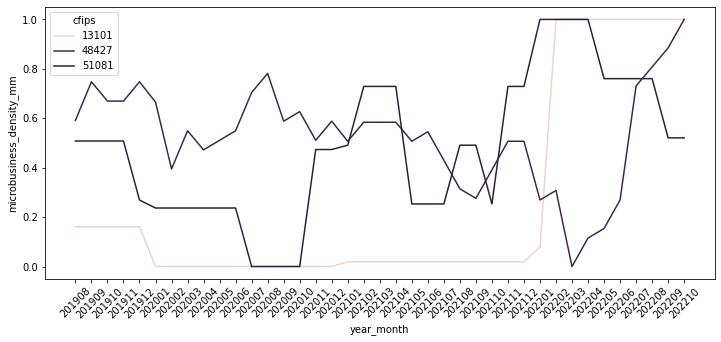

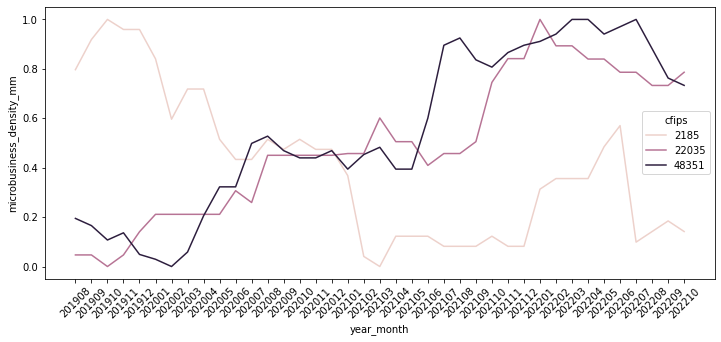

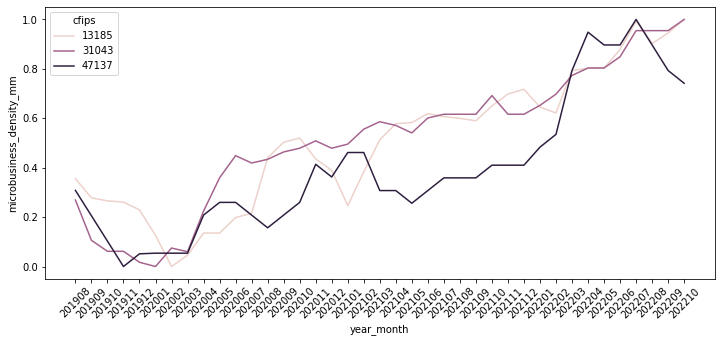

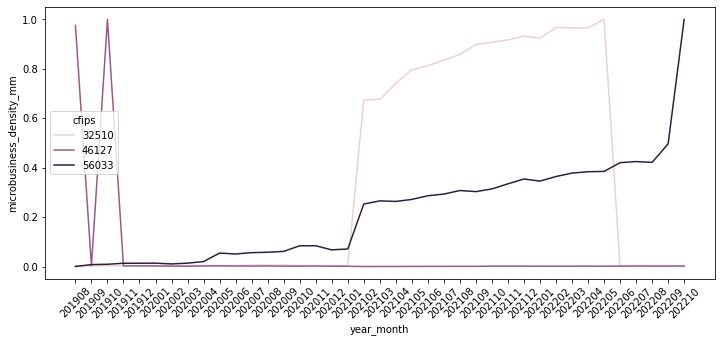

In [57]:
mm = preprocessing.MinMaxScaler() #正規化
b=pd.DataFrame(mm.fit_transform(train_each_cfips),columns=train_each_cfips.columns.to_list())
for i in train_df.groupby('cfips').count().index.to_list():
    train_df.loc[train_df['cfips']==i,'microbusiness_density_mm']=b[str(i)].to_list() 

plt.figure(figsize=(12, 5))
sns.lineplot(data=train_df[train_df['cfips'].isin(list_min_)],x='year_month',y='microbusiness_density_mm',hue='cfips')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=train_df[train_df['cfips'].isin(list_mid_1)],x='year_month',y='microbusiness_density_mm',hue='cfips')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=train_df[train_df['cfips'].isin(list_mid_2)],x='year_month',y='microbusiness_density_mm',hue='cfips')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=train_df[train_df['cfips'].isin(list_max_)],x='year_month',y='microbusiness_density_mm',hue='cfips')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

#標準偏差が小さいデータ（おそらく std が 0.1 以下のデータ）は、正規化するとバラツキが出やすくなります。
#逆に標準偏差が1.3以上ある場合は、正規化することでより明確に傾向を捉えることができる可能性があります。


In [59]:
cfips_lists=[]

train_each_cfips_crr=train_each_cfips[a.index.to_list()].corr()
list_=train_each_cfips_crr.index.to_list()

train_each_cfips_crr=train_each_cfips_crr[list_]
    
#クラスタ数 8 で　K-Means法を適用 
# https://pythondatascience.plavox.info/scikit-learn/%E3%82%AF%E3%83%A9%E3%82%B9%E3%82%BF%E5%88%86%E6%9E%90-k-means
train_each_cfips_crr['label'] = KMeans(n_clusters=8).fit_predict(train_each_cfips_crr)
cfips_lists.append(train_each_cfips_crr[train_each_cfips_crr['label']==0].index.to_list())
cfips_lists.append(train_each_cfips_crr[train_each_cfips_crr['label']==1].index.to_list())
cfips_lists.append(train_each_cfips_crr[train_each_cfips_crr['label']==2].index.to_list())
cfips_lists.append(train_each_cfips_crr[train_each_cfips_crr['label']==3].index.to_list())
cfips_lists.append(train_each_cfips_crr[train_each_cfips_crr['label']==4].index.to_list())
cfips_lists.append(train_each_cfips_crr[train_each_cfips_crr['label']==5].index.to_list())
cfips_lists.append(train_each_cfips_crr[train_each_cfips_crr['label']==6].index.to_list())
cfips_lists.append(train_each_cfips_crr[train_each_cfips_crr['label']==7].index.to_list())
cfips_all_lists=train_each_cfips_crr.index.to_list()
# cfips_lists.append(train_each_cfips_crr[train_each_cfips_crr['label']==8].index.to_list())
# cfips_lists.append(train_each_cfips_crr[train_each_cfips_crr['label']==9].index.to_list())

<function matplotlib.pyplot.show(*args, **kw)>

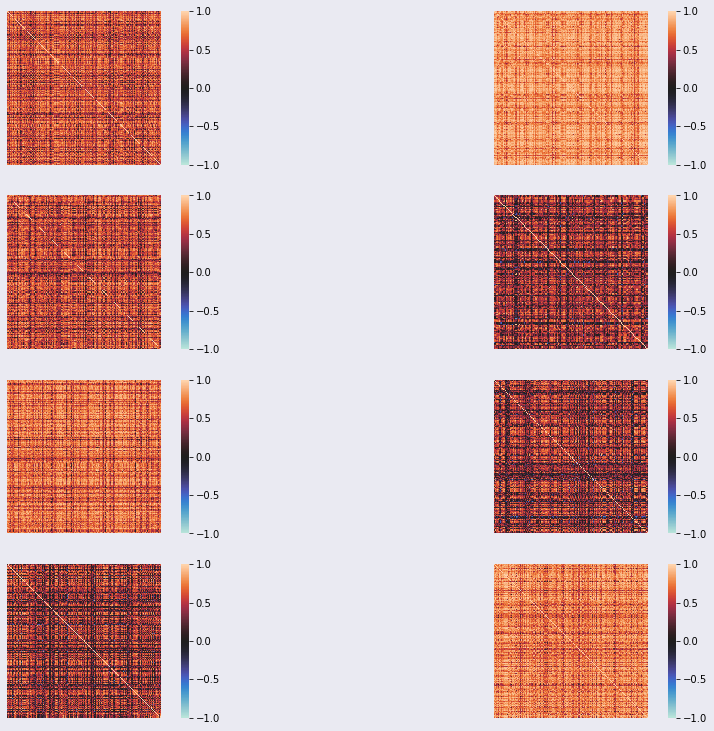

In [60]:
fig, axes = plt.subplots(4, 2, figsize=(16,13), facecolor='#EAEAF2')
sns.heatmap(train_each_cfips[cfips_lists[0]].corr(), square=True, vmax=1, vmin=-1, center=0,ax=axes[0,0],xticklabels=False,yticklabels=False)
sns.heatmap(train_each_cfips[cfips_lists[1]].corr(),square=True, vmax=1, vmin=-1, center=0,ax=axes[0,1],xticklabels=False,yticklabels=False)
sns.heatmap(train_each_cfips[cfips_lists[2]].corr(),square=True, vmax=1, vmin=-1, center=0,ax=axes[1,0],xticklabels=False,yticklabels=False)
sns.heatmap(train_each_cfips[cfips_lists[3]].corr(),square=True, vmax=1, vmin=-1, center=0,ax=axes[1,1],xticklabels=False,yticklabels=False)
sns.heatmap(train_each_cfips[cfips_lists[4]].corr(),square=True, vmax=1, vmin=-1, center=0,ax=axes[2,0],xticklabels=False,yticklabels=False)
sns.heatmap(train_each_cfips[cfips_lists[5]].corr(),square=True, vmax=1, vmin=-1, center=0,ax=axes[2,1],xticklabels=False,yticklabels=False)
sns.heatmap(train_each_cfips[cfips_lists[6]].corr(),square=True, vmax=1, vmin=-1, center=0,ax=axes[3,0],xticklabels=False,yticklabels=False)
sns.heatmap(train_each_cfips[cfips_lists[7]].corr(),square=True, vmax=1, vmin=-1, center=0,ax=axes[3,1],xticklabels=False,yticklabels=False)
plt.show

In [61]:
for idx in range(len(cfips_lists)):
    cfips_lists[idx] = [int(i) for i in cfips_lists[idx]]



---
**prepare training data**

add some columns All the same month values ＋ census_starter data + shift data


---



census_starter.csv 

Examples of useful columns from the Census Bureau's American Community Survey (ACS) at data.census.gov. The percentage fields were derived from the raw counts provided by the ACS. All fields have a two year lag to match what information was avaiable at the time a given microbusiness data update was published.

pct_bb_[year] - The percentage of households in the county with access to broadband of any type. Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.
cfips - The CFIPS code.


pct_college_[year] - The percent of the population in the county over age 25 with a 4-year college degree. Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.


pct_foreign_born_[year] - The percent of the population in the county born outside of the United States. Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.


pct_it_workers_[year] - The percent of the workforce in the county employed in information related industries. Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.


median_hh_inc_[year] - The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

In [63]:
df_census.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [64]:
df_census_.head()

,year,cfips,bb,cl,fb,iw,hh
0,2017,1001,76.6,14.5,2.1,1.3,55317.0
1,2018,1001,78.9,15.9,2.0,1.1,58786.0
2,2019,1001,80.6,16.1,2.3,0.7,58731.0
3,2020,1001,82.7,16.7,2.3,0.6,57982.0
4,2021,1001,85.5,16.4,2.1,1.1,62660.0


In [62]:
year_list=[]
cfips_list=[]
bb_list=[] # % of households in the county with access to broadband
cl_list=[] # % of the population in the county over age 25 with a 4-year college degree
fb_list=[] # % of the population in the county born outside of the U.S.
iw_list=[] # % of the workforce in the county employed in information related industries
hh_list=[] # The median household income in the county

# census リストを rowがyearになるように変形
for i in train_df.groupby('cfips').count().index.to_list():
    year_list=year_list+[2017,2018,2019,2020,2021]
    cfips_list=cfips_list+[i,i,i,i,i]
    bb_list=bb_list+df_census[df_census['cfips']==int(i)].iloc[:,0:5].T.iloc[:,0].to_list()
    cl_list=cl_list+df_census[df_census['cfips']==int(i)].iloc[:,6:11].T.iloc[:,0].to_list()
    fb_list=fb_list+df_census[df_census['cfips']==int(i)].iloc[:,11:16].T.iloc[:,0].to_list()
    iw_list=iw_list+df_census[df_census['cfips']==int(i)].iloc[:,16:21].T.iloc[:,0].to_list()
    hh_list=hh_list+df_census[df_census['cfips']==int(i)].iloc[:,21:26].T.iloc[:,0].to_list()

df_census_=pd.DataFrame()
df_census_['year']=year_list
df_census_['cfips']=cfips_list
df_census_['bb']=bb_list
df_census_['cl']=cl_list
df_census_['fb']=fb_list
df_census_['iw']=iw_list
df_census_['hh']=hh_list

train_df['bb']=0
train_df['cl']=0
train_df['fb']=0
train_df['iw']=0
train_df['hh']=0

for i in train_df.groupby('cfips').count().index.to_list():
    for col in ['bb','cl','fb','iw','hh']:
        train_df.loc[(train_df['year']==2019)&(train_df['cfips']==i),col]=df_census_.loc[(df_census_['year']==2017)&(df_census_['cfips']==i),col].iloc[0]
        train_df.loc[(train_df['year']==2020)&(train_df['cfips']==i),col]=df_census_.loc[(df_census_['year']==2018)&(df_census_['cfips']==i),col].iloc[0]
        train_df.loc[(train_df['year']==2021)&(train_df['cfips']==i),col]=df_census_.loc[(df_census_['year']==2019)&(df_census_['cfips']==i),col].iloc[0]
        train_df.loc[(train_df['year']==2022)&(train_df['cfips']==i),col]=df_census_.loc[(df_census_['year']==2020)&(df_census_['cfips']==i),col].iloc[0]

#Complement with 0 because there is a column with null
train_df.loc[train_df['iw'].isnull(),'iw']=0
train_df.loc[train_df['hh'].isnull(),'hh']=0

lbl_state = preprocessing.LabelEncoder()
lbl_county = preprocessing.LabelEncoder()
lbl_state.fit(train_df['state'])
lbl_county.fit(train_df['county'])

train_df['county']=lbl_county.transform(train_df['county'])
train_df['state']=lbl_state.transform(train_df['state'])

each_sym=train_df.groupby(['state','year_month'])['microbusiness_density'].describe()
each_sym=each_sym.reset_index()
each_sym_mm=train_df.groupby(['state','year_month'])['microbusiness_density_mm'].describe()
each_sym_mm=each_sym_mm.reset_index()

train_df['mean']=0
train_df['std']=0
train_df['mean_mm']=0

for state in each_sym.groupby('state').count().index.to_list():
    for sym in each_sym.groupby('year_month').count().index.to_list():
        train_df.loc[(train_df['state']==state)&(train_df['year_month']==sym),'mean']=each_sym.loc[(each_sym['state']==state)&(each_sym['year_month']==sym),'mean'].iloc[0]
        train_df.loc[(train_df['state']==state)&(train_df['year_month']==sym),'std']=each_sym.loc[(each_sym['state']==state)&(each_sym['year_month']==sym),'std'].iloc[0]
        train_df.loc[(train_df['state']==state)&(train_df['year_month']==sym),'mean_mm']=each_sym_mm.loc[(each_sym_mm['state']==state)&(each_sym_mm['year_month']==sym),'mean'].iloc[0]
# shift https://note.nkmk.me/python-pandas-shift/
train_df['shift']=train_df['microbusiness_density'].shift(12)
train_df['shift_mm']=train_df['microbusiness_density_mm'].shift(12)
train_df['shift_mean']=train_df['mean'].shift(12)
train_df['shift_std']=train_df['std'].shift(12)
train_df['shift_mean_mm']=train_df['mean_mm'].shift(12)
train_df=train_df[(train_df['year']==2020)&(train_df['month']>=8)|(train_df['year']>2020)]

train_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,year_month,...,iw,hh,mean,std,mean_mm,shift,shift_mm,shift_mean,shift_std,shift_mean_mm
12,1001_2020-08-01,1001,82,0,2020-08-01,3.174679,1328,2020,8,202008,...,1.1,58786.0,2.207977,1.658468,0.473602,3.007682,0.212115,2.132323,1.595064,0.293701
13,1001_2020-09-01,1001,82,0,2020-09-01,3.205756,1341,2020,9,202009,...,1.1,58786.0,2.221185,1.676802,0.501982,2.884870,0.000000,2.124727,1.603060,0.269529
14,1001_2020-10-01,1001,82,0,2020-10-01,3.193804,1336,2020,10,202010,...,1.1,58786.0,2.215552,1.669648,0.477039,3.055843,0.295298,2.129766,1.610638,0.284770
15,1001_2020-11-01,1001,82,0,2020-11-01,3.038416,1271,2020,11,202011,...,1.1,58786.0,2.195417,1.638437,0.415235,2.993233,0.187160,2.149763,1.617939,0.323854
16,1001_2020-12-01,1001,82,0,2020-12-01,3.002558,1256,2020,12,202012,...,1.1,58786.0,2.184938,1.634190,0.387692,2.993233,0.187160,2.146385,1.626718,0.318618


In [ ]:
train_df.head(20)



---

training

---



In [66]:
#reg_all 全件学習（country依存しない）の作成
#train  < 2022/7   test 2022/8 <  = 3 months

features=[ 'state', 'year', 'month', 'bb', 'cl', 'fb', 'iw','hh','cfips']
target='microbusiness_density_mm' #normalized density

train_data=train_df[~(train_df['year']==2022)&(train_df['month']>8)]
test_data=train_df[(train_df['year']==2022)&(train_df['month']>7)]

X_train = train_data[features]
X_test = test_data[features]

y_train = train_data[target]
y_test = test_data[target]

reg_all = lgb.LGBMRegressor(boosting_type='dart'
                            ,n_estimators=5000
                            ,num_leaves=500
                            ,learning_rate=0.05)
reg_all.fit(X_train,y_train)

LGBMRegressor(boosting_type='dart', learning_rate=0.05, n_estimators=5000,
              num_leaves=500)

In [68]:
model_list=[]
score_list=[]
score_list_all=[]
cnt=0

#countyごとの学習？
for list_ in cfips_lists: #8つにクラスタリングされたcfipsの一覧 
    df_=train_df[train_df['cfips'].isin(list_)]
    train_data=df_[~(df_['year']==2022)&(df_['month']>8)]
    test_data=df_[(df_['year']==2022)&(df_['month']>7)]
    
    X=df_[features]
    X_train = train_data[features]
    X_test = test_data[features]
    
    y=df_[target]
    y_train = train_data[target]
    y_test = test_data[target]

    reg = lgb.LGBMRegressor(boosting_type='dart'
                            ,n_estimators=5000
                            ,num_leaves=500
                            ,learning_rate=0.05)
    reg.fit(X_train,y_train)
    reg_rmse=mean_squared_error(reg.predict(X_test), y_test)
    #ALLの学習結果を用いてPredict MSEを算出
    reg_rmse_all=mean_squared_error(reg_all.predict(X_test), y_test)
    

    print('number of cfips is : ',len(list_))
    print('mean_squared_error is : ',reg_rmse)
    print('mean_squared_error with all data model is : ',reg_rmse_all)
    
    score_list.append(reg_rmse)
    score_list_all.append(reg_rmse_all)
    
    reg.fit(X, y)
    model_list.append(reg)
    cnt=cnt+1

number of cfips is :  294
mean_squared_error is :  0.2420465674811555
mean_squared_error with all data model is :  0.14041682865641764
number of cfips is :  815
mean_squared_error is :  0.05450143341113976
mean_squared_error with all data model is :  0.1930890606960961
number of cfips is :  295
mean_squared_error is :  0.3473051552769006
mean_squared_error with all data model is :  0.26658464030211304
number of cfips is :  141
mean_squared_error is :  0.087386857022453
mean_squared_error with all data model is :  0.08257888258063928
number of cfips is :  501
mean_squared_error is :  0.2579733915782115
mean_squared_error with all data model is :  0.27615550694907026
number of cfips is :  193
mean_squared_error is :  0.0671927472924491
mean_squared_error with all data model is :  0.07946463424350152
number of cfips is :  188
mean_squared_error is :  0.08834173034812234
mean_squared_error with all data model is :  0.08497041505069437
number of cfips is :  708
mean_squared_error is :  0.03

In [78]:
reg_all.fit(train_df[features], train_df[target])

LGBMRegressor(boosting_type='dart', learning_rate=0.05, n_estimators=5000,
              num_leaves=500)



---
make prediction


---




In [77]:
test_df['bb']=0
test_df['cl']=0
test_df['fb']=0
test_df['iw']=0
test_df['hh']=0
test_df['shift']=0

for i in train_df.groupby('cfips').count().index.to_list():
    for month in [11,12]:
        test_df.loc[(test_df['year']==2022)&(test_df['month']==month)&(test_df['cfips']==i),'shift']=train_df.loc[(train_df['year']==2021)&(train_df['month']==month)&(train_df['cfips']==i),'microbusiness_density'].iloc[0]
        test_df.loc[(test_df['year']==2022)&(test_df['month']==month)&(test_df['cfips']==i),'shift_mm']=train_df.loc[(train_df['year']==2021)&(train_df['month']==month)&(train_df['cfips']==i),'microbusiness_density_mm'].iloc[0]
        test_df.loc[(test_df['year']==2022)&(test_df['month']==month)&(test_df['cfips']==i),'shift_mean']=train_df.loc[(train_df['year']==2021)&(train_df['month']==month)&(train_df['cfips']==i),'mean'].iloc[0]
        test_df.loc[(test_df['year']==2022)&(test_df['month']==month)&(test_df['cfips']==i),'shift_std']=train_df.loc[(train_df['year']==2021)&(train_df['month']==month)&(train_df['cfips']==i),'std'].iloc[0]
        test_df.loc[(test_df['year']==2022)&(test_df['month']==month)&(test_df['cfips']==i),'shift_mean_mm']=train_df.loc[(train_df['year']==2021)&(train_df['month']==month)&(train_df['cfips']==i),'mean_mm'].iloc[0]
        
    for month in [1,2,3,4,5,6]:
        test_df.loc[(test_df['year']==2023)&(test_df['month']==month)&(test_df['cfips']==i),'shift']=train_df.loc[(train_df['year']==2022)&(train_df['month']==month)&(train_df['cfips']==i),'microbusiness_density'].iloc[0]
        test_df.loc[(test_df['year']==2023)&(test_df['month']==month)&(test_df['cfips']==i),'shift_mm']=train_df.loc[(train_df['year']==2022)&(train_df['month']==month)&(train_df['cfips']==i),'microbusiness_density_mm'].iloc[0]
        test_df.loc[(test_df['year']==2023)&(test_df['month']==month)&(test_df['cfips']==i),'shift_mean']=train_df.loc[(train_df['year']==2022)&(train_df['month']==month)&(train_df['cfips']==i),'mean'].iloc[0]
        test_df.loc[(test_df['year']==2023)&(test_df['month']==month)&(test_df['cfips']==i),'shift_std']=train_df.loc[(train_df['year']==2022)&(train_df['month']==month)&(train_df['cfips']==i),'std'].iloc[0]
        test_df.loc[(test_df['year']==2023)&(test_df['month']==month)&(test_df['cfips']==i),'shift_mean_mm']=train_df.loc[(train_df['year']==2022)&(train_df['month']==month)&(train_df['cfips']==i),'mean_mm'].iloc[0]

    for col in ['bb','cl','fb','iw','hh']:
        test_df.loc[(test_df['year']==2022)&(test_df['cfips']==i),col]=df_census_.loc[(df_census_['year']==2020)&(df_census_['cfips']==i),col].iloc[0]
        test_df.loc[(test_df['year']==2023)&(test_df['cfips']==i),col]=df_census_.loc[(df_census_['year']==2021)&(df_census_['cfips']==i),col].iloc[0]

test_df.loc[test_df['iw'].isnull(),'iw']=0
test_df.loc[test_df['hh'].isnull(),'hh']=0
test_df['county']=0
test_df['state']=0

for cf in test_df.groupby('cfips').count().index.to_list():
    test_df.loc[test_df['cfips']==cf,'county']=train_df.loc[train_df['cfips']==cf,'county'].iloc[0]
    test_df.loc[test_df['cfips']==cf,'state']=train_df.loc[train_df['cfips']==cf,'state'].iloc[0]

test_df.head()

,row_id,cfips,first_day_of_month,year,month,year_month,bb,cl,fb,iw,hh,shift,shift_mm,shift_mean,shift_std,shift_mean_mm,county,state
0,1001_2022-11-01,1001,2022-11-01,2022,11,202211,82.7,16.7,2.3,0.6,57982.0,3.200948,0.545918,2.271062,1.593666,0.543703,82,0
1,1003_2022-11-01,1003,2022-11-01,2022,11,202211,85.1,20.2,3.4,1.0,61756.0,7.900597,0.495719,2.271062,1.593666,0.543703,89,0
2,1005_2022-11-01,1005,2022-11-01,2022,11,202211,64.6,7.3,2.6,1.1,34990.0,1.151890,0.678078,2.271062,1.593666,0.543703,100,0
3,1007_2022-11-01,1007,2022-11-01,2022,11,202211,76.1,7.4,1.6,1.7,51721.0,1.231665,0.286539,2.271062,1.593666,0.543703,149,0
4,1009_2022-11-01,1009,2022-11-01,2022,11,202211,79.6,8.9,4.4,1.1,48922.0,1.733947,0.625111,2.271062,1.593666,0.543703,164,0


In [1]:
#prediction
test_df['prediction_all']=reg_all.predict(test_df[features])

for pickup_list,model_,score_,score_all_ in zip(cfips_lists,model_list,score_list,score_list_all):
    test_df.loc[test_df['cfips'].isin(pickup_list),'prediction']=model_.predict(test_df.loc[test_df['cfips'].isin(pickup_list),features])
    
    if (score_/score_all_)<0.5:
        print('take the mean')
        print('number of cfips is : ',len(pickup_list))
        test_df.loc[test_df['cfips'].isin(pickup_list),'prediction']=(test_df.loc[test_df['cfips'].isin(pickup_list),'prediction']+test_df.loc[test_df['cfips'].isin(pickup_list),'prediction_all'])/2
        

test_df.head()

NameError: ignored

In [ ]:
#inverse the normalized target
test_df_mm=pd.DataFrame()

for cfips in train_df.groupby('cfips').count().index.to_list():
    test_df_mm[str(cfips)]=test_df.loc[test_df['cfips']==cfips,'prediction'].to_list()
test_df_mm=pd.DataFrame(mm.inverse_transform(test_df_mm),columns=test_df_mm.columns.to_list())

# inverse_list=cfips_lists[3]
for cfips in train_df.groupby('cfips').count().index.to_list():
    test_df.loc[test_df['cfips']==cfips,'prediction']=test_df_mm[str(cfips)].to_list()

test_df.head()

In [ ]:
submission=pd.read_csv('/content/drive/MyDrive/Kaggle/microbusiness/sample_submission.csv')
submission['microbusiness_density']=test_df['prediction']
submission.to_csv('submission.csv', index=False)